# Ichimoku Cloud Study
## Random Forrest

I want to predict price movements of S&P 500 stocks given bullish crossover signals from Ichimoku clouds. The signal 
has two criteria:
1. Conversion line moves above base line (Crossover)
2. Price is above cloud

### Features
#### Existing
1. ~~open~~
2. ~~high~~
3. ~~low~~
4. ~~close~~
5. ~~volume~~
6. ~~dividend amount~~

#### Technical Indicators
1. ~~tenken_sen~~ (replaced with close_diff_tenkan_sen_percent)
2. ~~kijun_sen~~ (replaced with close_diff_kijun_sen_percent)
3. ~~senkou_span_a~~ (replaced with close_diff_senkou_span_a_percent)
4. ~~senkou_span_b~~ (replaced with close_diff_senkou_span_b_percent)
5. ~~chikou_span~~ (forward bias)
6. RSI (period = 14 day)
7. RMI (time_period = 14 day, momentum_period = 5 day)
8. MFI (period = 14 day)
9. MACD Hist (fastperiod = 12 day, slowperiod = 26 day, signalperiod = 9 day)
10. Rel. SPY (TODO)

#### Engineered
1. close_diff_tenkan_sen_percent
2. close_diff_kijun_sen_percent
3. close_diff_senkou_span_a_percent
4. close_diff_senkou_span_b_percent
5. days_since_earnings
6. crossover_difference
7. crossover_indicator
8. close_price_diff_1_day
9. close_to_365_day_high
10. close_to_365_day_low
12. close_to_{N*7}_day_low
13. volume_percent_of_2_week_total
14. dividend_amount_to_close

### Issues
- RandomForestRegressor only predicts positive targets.

In [8]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

import importlib

# After updating the package
import tools.data_helper
importlib.reload(tools.data_helper)

from tools.machine_learning_helper import find_first_below_threshold
from tools.data_helper import process_data
from sklearn.metrics import mean_squared_log_error, mean_squared_error
# TECH DEBT: determine which symbols have high accuracy...

### Load data

### Earnings Dates

### Feature Engineering

In [9]:
data_path = '../../../res/data/s_and_p_study_data.h5'
df_dict, dropped_symbols, target_col = process_data(data_path, days_into_future=10)

/prices/A
/prices/AAL
/prices/AAPL
/prices/ABBV
/prices/ABNB
/prices/ABT
/prices/ACGL
/prices/ACN
/prices/ADBE
/prices/ADI
/prices/ADM
/prices/ADP
/prices/ADSK
/prices/AEE
/prices/AEP
/prices/AES
/prices/AFL
/prices/AIG
/prices/AIZ
/prices/AJG
/prices/AKAM
/prices/ALB
/prices/ALGN
/prices/ALK
/prices/ALL
/prices/ALLE
/prices/AMAT
/prices/AMCR
/prices/AMD
/prices/AME
/prices/AMGN
/prices/AMP
/prices/AMT
/prices/AMZN
/prices/ANET
/prices/ANSS
/prices/AON
/prices/AOS
/prices/APA
/prices/APD
/prices/APH
/prices/APTV
/prices/ARE
/prices/ATO
/prices/AVB
/prices/AVGO
/prices/AVY
/prices/AWK
/prices/AXON
/prices/AXP
/prices/AZO
/prices/BA
/prices/BAC
/prices/BALL
/prices/BAX
/prices/BBWI
/prices/BBY
/prices/BDX
/prices/BEN
/prices/BF-B
/prices/BG
/prices/BIIB
/prices/BIO
/prices/BK
/prices/BKNG
/prices/BKR
/prices/BLK
/prices/BMY
/prices/BR
/prices/BRK-B
/prices/BRO
/prices/BSX
/prices/BWA
/prices/BX
/prices/BXP
/prices/C
/prices/CAG
/prices/CAH
/prices/CARR
/prices/CAT
/prices/CB
/prices/CBOE

In [10]:
# TECH DEBT: optimize hyperparameter

test_length = 2
min_date = pd.Timestamp('2010-10-01 16:00:00', tz='US/Eastern')
final_df_test_x_list = []
final_df_test_y_list = []
final_df_train_x_list = []
final_df_train_y_list = []
for key, df in df_dict.items():
    final_df = df.loc[df.index >= min_date]
    final_df = final_df.reset_index(drop=True)
    
    end_point = len(final_df)
    x = end_point - test_length
    final_df_train = final_df.loc[:x - 1, :]
    final_df_test = final_df.loc[x:, :]
    
    final_df_test_x_list.append(final_df_test.loc[:, [col for col in final_df_test.columns if col not in [target_col]]])
    final_df_test_y_list.append(final_df_test[target_col])
    final_df_train_x_list.append(final_df_train.loc[:, [col for col in final_df_test.columns if col not in [target_col]]])
    final_df_train_y_list.append(final_df_train[target_col])
    
final_df_test_x = pd.concat(final_df_test_x_list)
final_df_test_y = pd.concat(final_df_test_y_list)
final_df_train_x = pd.concat(final_df_train_x_list)
final_df_train_y = pd.concat(final_df_train_y_list)


In [21]:
n_features_to_select = 30
print("Starting model train..")
rfe = RFE(RandomForestRegressor(n_estimators=100, random_state=1), n_features_to_select=n_features_to_select)
fit = rfe.fit(final_df_train_x, final_df_train_y)
y_pred = fit.predict(final_df_test_x)

Starting model train..


In [22]:

y_true = final_df_test_y.values

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
rmse

0.03867920132402513

In [23]:
# Get the mask of the selected features
selected_features_mask = rfe.support_

# Get the rankings of the features
feature_ranking = rfe.ranking_

# Get the names of the selected features
selected_features = final_df_train_x.columns[selected_features_mask]

print("Selected features:", list(selected_features))
print("Feature ranking:", feature_ranking)

Selected features: ['spy_close_diff_tenkan_sen_percent', 'spy_close_diff_kijun_sen_percent', 'spy_close_diff_senkou_span_a_percent', 'spy_close_diff_senkou_span_b_percent', 'days_since_earnings', 'rsi', 'mfi', 'rmi', 'macd', 'macd_signal', 'macd_hist', 'close_price_diff_1_day', 'crossover_difference', 'volume_percent_of_2_week_total', 'close_to_365_day_high', 'close_to_365_day_low', 'close_to_7_day_low', 'close_to_21_day_low', 'close_to_35_day_high', 'close_to_35_day_low', 'close_to_49_day_low', 'close_to_56_day_low', 'close_to_63_day_low', 'close_to_70_day_low', 'close_to_77_day_low', 'close_to_84_day_high', 'close_to_84_day_low', 'close_diff_kijun_sen_percent', 'close_diff_senkou_span_a_percent', 'close_diff_senkou_span_b_percent']
Feature ranking: [ 1  1  1  1  1  1  1  1  1  1  1  1  1 18  1 17  2  1  1  8  1 14  3 11
  1 10  7  1  1  9  4 13  1 15  1  6  1 16  1 12  1  1  1  5  1  1  1]


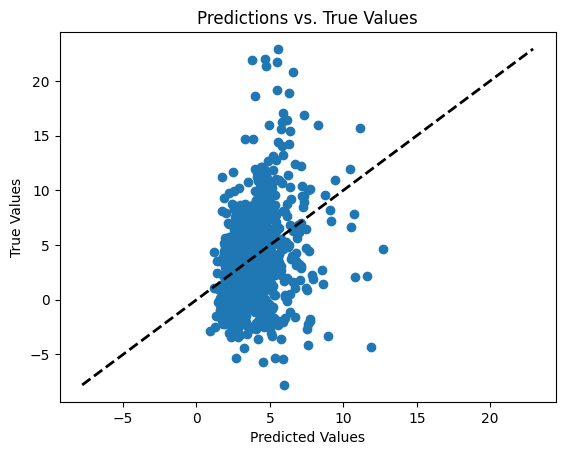

In [24]:
import matplotlib.pyplot as plt
# Optionally, add a line for perfect correlation for reference
actual_values = y_true * 100
predicted_values = y_pred * 100
plt.scatter(predicted_values, actual_values)
plt.plot([actual_values.min(), actual_values.max()], [actual_values.min(), actual_values.max()], 'k--', lw=2)
plt.title('Predictions vs. True Values')
plt.ylabel('True Values')
plt.xlabel('Predicted Values')
plt.show()


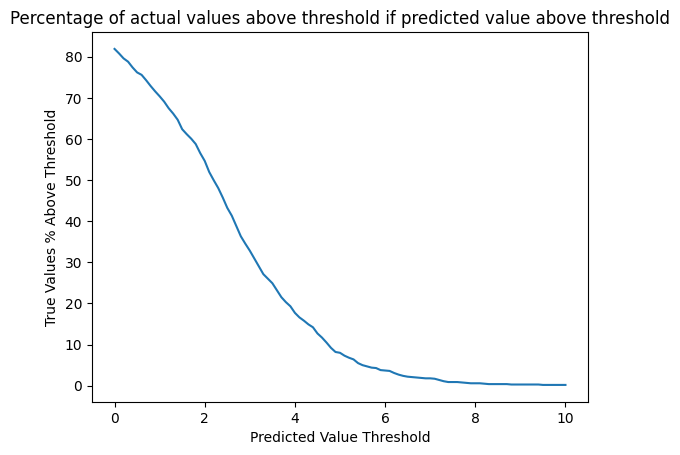

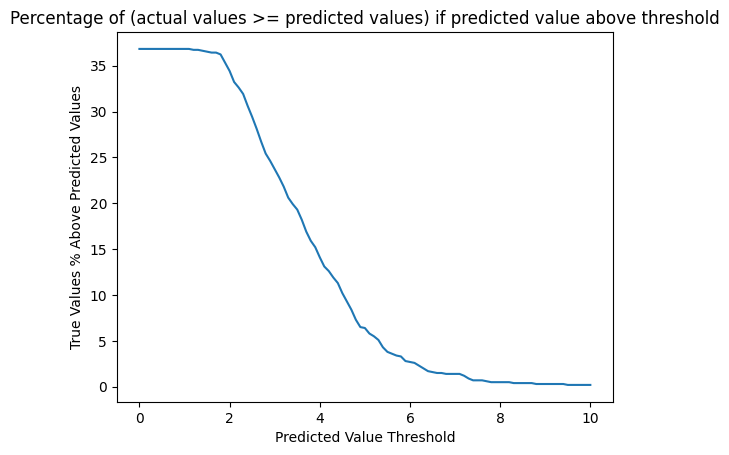

In [25]:
actual_vs_thresh_prob = []
x = np.linspace(0, 10, 101)
for prediction_threshold in x:
    # what percentage of predicted_values above prediction_threshold had an actual_value above prediction_threshold
    actual_vs_thresh_prob.append(100 * ((actual_values > prediction_threshold * 1.0) & (predicted_values > 
                                                                              prediction_threshold)).mean())

plt.plot(x, actual_vs_thresh_prob)
plt.title('Percentage of actual values above threshold if predicted value above threshold')
plt.xlabel('Predicted Value Threshold')
plt.ylabel('True Values % Above Threshold')
plt.show()

actual_vs_pred_prob = []
# x = np.linspace(0, 10, 51)
for prediction_threshold in x:
    # what percentage of predicted_values above prediction_threshold had an actual_value above prediction_threshold
    actual_vs_pred_prob.append(100 * ((actual_values >= predicted_values) & (predicted_values > 
                                                                              prediction_threshold)).mean())

plt.plot(x, actual_vs_pred_prob)
plt.title('Percentage of (actual values >= predicted values) if predicted value above threshold')
plt.xlabel('Predicted Value Threshold')
plt.ylabel('True Values % Above Predicted Values')
plt.show()

In [26]:
x[find_first_below_threshold(actual_vs_thresh_prob, 50)]

2.2

In [27]:

# Use MSLE to penalize underestimates...need to modify to penalize overestimates
# Ensure that neither actual_values nor predicted_values contain negative values
actual_values_adj = np.maximum((1 + actual_values/100), 0)
predicted_values_adj = np.maximum((1 + predicted_values/100), 0)
# Swap the actual and predicted values to punish overestimates.
modified_msle = mean_squared_log_error(predicted_values_adj, actual_values_adj)

print("Mean Squared Logarithmic Error:", modified_msle)
"Mean Squared Logarithmic Error: 0.0003165310587558688"

Mean Squared Logarithmic Error: 0.0003547861480483068


'Mean Squared Logarithmic Error: 0.0003165310587558688'

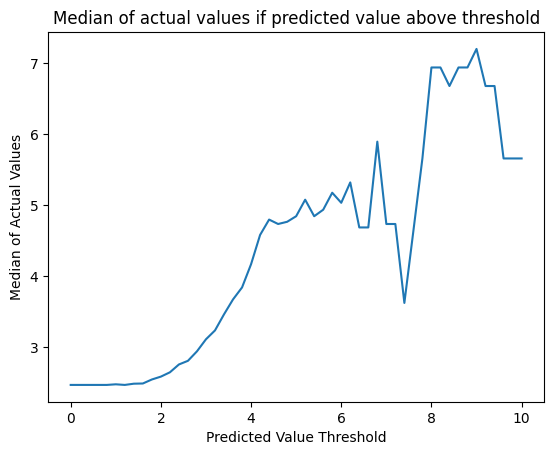

In [28]:
y = []
x = np.linspace(0, 10, 51)
for prediction_threshold in x:
    y.append(np.median(actual_values[predicted_values >= prediction_threshold]))
plt.plot(x, y)
plt.title('Median of actual values if predicted value above threshold')
plt.xlabel('Predicted Value Threshold')
plt.ylabel('Median of Actual Values')
plt.show()

In [29]:
slice = actual_values[predicted_values >= 4]
np.median(slice)
# slice
# y

4.166507978824695